## CLTV Prediction with BG-NBD and Gamma-Gamma

CLTV = BG/NGD * Gamma-Gamma

CLTV = (Customer Value / Churn Rate) * Profit Margin 

CLTV = Expected Average Profit * Expected Number of Transaction

Customer Value = Average Order Value * Purchase Frequency

Average Order Value (total_price / total_transaction) -islem basina ort harcama 

In [8]:
# !pip install lifetimes

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)
pd.set_option("display.expand_frame_repr", False)

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_df(dataframe):
    print('------------ Shape ------------')
    print(dataframe.shape)
    print('------------ Types ------------')
    print(dataframe.dtypes)
    print('------------ Describe ------------')
    print(dataframe.describe().T)
    print('------------ NA ------------')
    print(dataframe.isnull().sum())    

df_ = pd.read_excel("/Users/betulyilmaz/Desktop/Miuul/CRM Analytics/Datasets/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [10]:
check_df(df)

------------ Shape ------------
(541910, 8)
------------ Types ------------
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
------------ Describe ------------
                  count                           mean                  min                  25%                  50%                  75%                  max       std
Quantity    541910.0000                         9.5522          -80995.0000               1.0000               3.0000              10.0000           80995.0000  218.0810
InvoiceDate      541910  2011-07-04 13:35:22.342307584  2010-12-01 08:26:00  2011-03-28 11:34:00  2011-07-19 17:17:00  2011-10-19 11:27:00  2011-12-09 12:50:00       NaN
Price       541910.0000                         4.6111          -11062.0600               1.2500               2.0800        

In [11]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

df["TotalPrice"] = df["Quantity"] * df["Price"]

today_date = dt.datetime(2011, 12, 11)

In [12]:
check_df(df)

------------ Shape ------------
(397885, 9)
------------ Types ------------
Invoice                object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
TotalPrice            float64
dtype: object
------------ Describe ------------
                  count                           mean                  min                  25%                  50%                  75%                  max       std
Quantity    397885.0000                        11.8308               1.0000               2.0000               6.0000              12.0000             298.5000   25.5231
InvoiceDate      397885  2011-07-10 23:41:56.419316992  2010-12-01 08:26:00  2011-04-07 11:12:00  2011-07-31 14:39:00  2011-10-20 14:33:00  2011-12-09 12:50:00       NaN
Price       397885.0000                         2.8935               0.0010               1.250

In [25]:
# CLTV veri yapisinin olusturulmasi

# recency: son satin alma uzerinden gecen zaman (haftalik)
# T: musterinin yasi. Analiz taihinden ne kadar sure once ilk satin almasini yapmis)
# frequency: tekrar eden toplam satin alma sayisi (frequency>1)
# monetary: satin alma basina ortalama kazanc

cltv_df = df.groupby("Customer ID").agg({
    "InvoiceDate": [lambda x: (x.max() - x.min()).days,
                    lambda x: (today_date - x.min()).days],
    "Invoice": lambda x: x.nunique(),
    "TotalPrice": lambda x: x.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df= cltv_df[(cltv_df["frequency"] > 1)]

cltv_df["recency"] = cltv_df["recency"] / 7

cltv_df["T"] = cltv_df["T"] / 7

cltv_df.head()


,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,442.6950
12352.0000,37.1429,42.4286,8,219.5425
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,575.2100


In [26]:
# BG-NBD modelin kurulmasi

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df["frequency"],
        cltv_df["recency"],
        cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

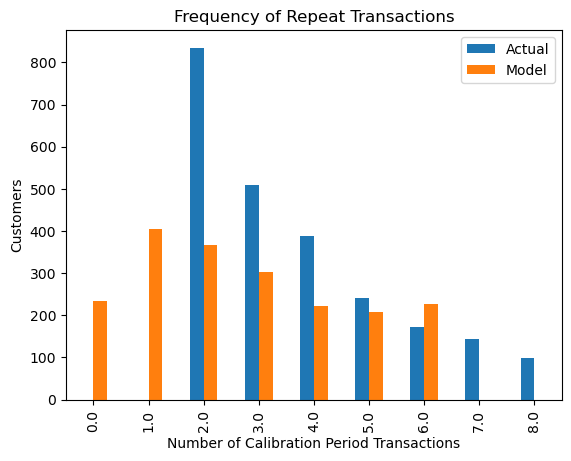

In [33]:
# 1 hafta icinde en cok satin alma bekledigimiz 10 musteri

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

# 1 ay icinde en cok satin alma bekledigimiz

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

# 3 ayda tum sirketin beklenen satis sayisi

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

plot_period_transactions(bgf)
plt.show()

In [38]:
# Gamma-Gamma modelinin kurulmasi

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df["frequency"], cltv_df["monetary"])

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_1_week,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,1.5139,0.3796,4.5080,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0460,0.0115,0.1363,5029.4196
12435.0000,26.8571,38.2857,2,3914.9450,0.3041,0.0763,0.9035,4288.9440
12409.0000,14.7143,26.1429,3,3690.8900,0.4674,0.1174,1.3854,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,1.0379,0.2603,3.0896,3917.1297
18102.0000,52.2857,52.5714,60,3859.7391,3.8636,0.9685,11.5112,3870.9969
12753.0000,48.4286,51.8571,6,3571.5650,0.5028,0.1261,1.4973,3678.5783
14646.0000,50.4286,50.7143,73,3646.0757,4.8119,1.2064,14.3340,3654.8148
15749.0000,13.8571,47.5714,3,3028.7800,0.1116,0.0280,0.3320,3216.0523


In [41]:
# BG-NBD ve GG modeli ile CLTV hesaplamasi

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary"],
                                   time=3, # 3 aylik
                                   freq="W", # T'nin frekns bilgisi
                                   discount_rate=0.01)

cltv = cltv.reset_index()

cltv.head()

,Customer ID,clv
0,12347.0000,1128.4477
1,12348.0000,538.8089
2,12352.0000,517.5000
3,12356.0000,1083.0903
4,12358.0000,966.6727


In [42]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_1_week,expected_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,4.8119,1.2064,14.3340,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,3.8636,0.9685,11.5112,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,2.8955,0.7287,8.5526,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,1.5139,0.3796,4.5080,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,12.4722,3.1264,37.1641,692.3264,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,2.9815,0.7474,8.8830,2874.1987,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,3.5005,0.8775,10.4298,2110.7542,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,2.0298,0.5088,6.0476,2950.5801,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,1.9068,0.4781,5.6801,2223.8850,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,3.1946,0.8008,9.5186,1280.2183,12966.1347


In [44]:
# cltv'ye gore segmentlerin olusturulmasi

cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(20)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_1_week,expected_purc_3_month,expected_average_profit,clv,segment
1122,14646.0000,50.4286,50.7143,73,3646.0757,4.8119,1.2064,14.3340,3654.8148,55741.0845,A
2761,18102.0000,52.2857,52.5714,60,3859.7391,3.8636,0.9685,11.5112,3870.9969,47412.5801,A
843,14096.0000,13.8571,14.5714,17,3163.5882,2.8955,0.7287,8.5526,3196.4361,29061.6614,A
36,12415.0000,44.7143,48.2857,21,5724.3026,1.5139,0.3796,4.5080,5772.1782,27685.1000,A
1257,14911.0000,53.1429,53.4286,201,691.7101,12.4722,3.1264,37.1641,692.3264,27377.4115,A
2458,17450.0000,51.2857,52.5714,46,2863.2749,2.9815,0.7474,8.8830,2874.1987,27166.0643,A
874,14156.0000,51.5714,53.1429,55,2104.0267,3.5005,0.8775,10.4298,2110.7542,23424.4032,A
2487,17511.0000,52.8571,53.4286,31,2933.9431,2.0298,0.5088,6.0476,2950.5801,18986.6123,A
2075,16684.0000,50.4286,51.2857,28,2209.9691,1.9068,0.4781,5.6801,2223.8850,13440.4131,A
650,13694.0000,52.7143,53.4286,50,1275.7005,3.1946,0.8008,9.5186,1280.2183,12966.1347,A


In [45]:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                          recency                        T                    frequency               monetary                      expected_purc_1_month                 expected_purc_1_week                 expected_purc_3_month                  expected_average_profit                        clv                       
              count           sum       mean   count        sum    mean count        sum    mean     count   sum    mean    count         sum     mean                 count      sum   mean                count      sum   mean                 count       sum   mean                   count         sum     mean count          sum      mean
segment                                                                                                                                                                                                                                                                                                                                           
D               712 11077635.0000 15558.4761     712 15716.5714 22.0738   712 28811.0000 40.4649       712  2182  3.0646      712 130981.7123 183.9631                   712 201.4774 0.2830                  712  50.5898 0.0711                   712  598.0905 0.8400                     712 141999.6650 199.4377   712  102027.4901  143.2970
C               711 10885150.0000 15309.6343     711 21806.1429 30.6697   711 27097.0000 38.1111       711  2912  4.0956      711 193174.9847 271.6948                   711 341.3936 0.4802                  711  85.7309 0.1206                   711 1013.2176 1.4251                     711 206179.7461 289.9856   711  270743.0065  380.7919
B               711 10915854.0000 15352.8186     711 20985.0000 29.5148   711 24751.1429 34.8117       711  3869  5.4416      711 265517.6312 373.4425                   711 459.6926 0.6465                  711 115.5066 0.1625                   711 1362.6595 1.9165                     711 280058.9431 393.8944   711  489356.3925  688.2650
A               711 10627572.0000 14947.3586     711 22333.1429 31.4109   711 24518.1429 34.4840       711  8076 11.3586      711 469159.4581 659.8586                   711 774.3298 1.0891                  711 194.4993 0.2736                   711 2297.1448 3.2309                     711 487674.7239 685.8998   711 1580097.9284 2222.3600